<a href="https://colab.research.google.com/github/aabhaysri/ph2oanalytics/blob/machine-learning/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import os
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import tensorflow as tf

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from google.colab import drive 
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Data Sets - pH2O Analytics/Datasets/Cleansed Data")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
files = os.listdir()
files = list(filter(lambda x: x.endswith(".csv"), files))

dfs = []
fileNames = []

for file in files:
    fileNames.append(str(file))
    df = pd.read_csv(file,
                     low_memory=False,
                     usecols=[2, 4],
                     skiprows=lambda x: 2 if x == 2 else x % 2 == 1,
                     parse_dates=["datetime"],
                     date_parser=lambda x: pd.to_datetime(
                         x, format="%m/%d/%Y %H:%M"),
                     index_col=["datetime"])
    df.columns = ["ph"]
    dfs.append(df)

In [4]:
temp = []
for i in range(len(dfs)):
    df = pd.DataFrame()
    df["v1"] = dfs[i].index[:-1]
    df["v2"] = dfs[i].index[1:]
    time_gaps = df["v1"] - df["v2"]

    for z in range(len(time_gaps)):
        time_gaps[z] = time_gaps[z].total_seconds()

    if abs(time_gaps.min()) > 2628000:
        continue
    else:
        temp.append(dfs[i])

In [30]:
dfs = temp
data = dfs[0].filter(["ph"])
data["time"] = data.index
timed = int((data.index[1] - data.index[0]).total_seconds())
data["month"] = data.index.month.astype(str).astype("category")
data["year"] = data.index.year.astype(str).astype("category")
data["group"] = 0
data["time_idx"] = (
    (data.index - data.index[0]).total_seconds()/timed).astype("int64")
data.index = range(0, len(data.index))

In [50]:
#max_prediction_length = int(43800 * 60 / timed)
max_prediction_length=1000
training_cutoff = data["time_idx"].max() - max_prediction_length

In [51]:
max_encoder_length = max_prediction_length*2
training = TimeSeriesDataSet(data[lambda x: x.time_idx <= training_cutoff],
                             time_idx="time_idx",
                             target="ph",
                             group_ids=["group"],
                             time_varying_unknown_reals=["ph"],
                             time_varying_known_reals=["time"],
                             time_varying_known_categoricals=["month", "year"],
                             min_encoder_length=max_encoder_length // 2,
                             max_encoder_length=max_encoder_length,
                             max_prediction_length=max_prediction_length,
                             allow_missing_timesteps=True,
                             add_encoder_length=True
                             )

In [52]:
batch_size=64
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size*10, num_workers=0)

In [53]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

0.04099996015429497

In [54]:
print(validation)

In [55]:
trainer = pl.Trainer(gpus=1,
                    gradient_clip_val=.1)

tft = TemporalFusionTransformer.from_dataset(training,
                                            learning_rate=.06,
                                            hidden_size=6,
                                            attention_head_size=1,
                                            dropout=.2,
                                            hidden_continuous_size=6,
                                            reduce_on_plateau_patience=4)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [56]:
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10,
    min_lr=1e-6,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 84    
3  | prescalers                         | ModuleDict                      | 36    
4  | static_variable_selection          | VariableSelectionNetwork        | 192   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 612   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 345   
7  | static_context_variable_selection  | GatedResidualNetwork            | 180   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 180   
9  | static_context_initial_cell_lstm 

Restored states from the checkpoint file at /content/drive/My Drive/Data Sets - pH2O Analytics/Datasets/Cleansed Data/lr_find_temp_model.ckpt


suggested learning rate: 0.39810717055349754


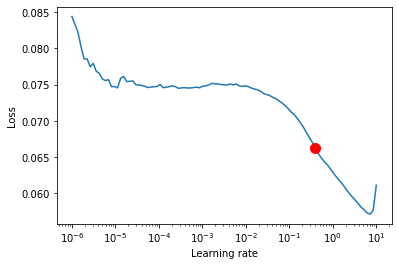

In [57]:
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()